In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [2]:
df = pd.read_csv('/kaggle/input/politics-on-reddit/reddit_politics.csv')
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,A Right Wing Group in Texas Is Making up Fake ...,166,ov1ll3,https://www.vice.com/en/article/wx5bg5/blm-whi...,34,1.627710e+09,NaN,2021-07-31 08:35:47
1,DOJ sues Texas over Gov. Abbott’s order for la...,85,ouwc9i,https://www.kxan.com/news/texas-politics/doj-s...,17,1.627688e+09,NaN,2021-07-31 02:26:12
2,"From white evangelicals to QAnon believers, wh...",57,ouqkxi,https://www.modbee.com/news/coronavirus/articl...,27,1.627671e+09,NaN,2021-07-30 21:45:09
3,DeSantis says he’ll sign order allowing parent...,269,oun2lc,https://www.orlandosentinel.com/politics/os-ne...,138,1.627660e+09,NaN,2021-07-30 18:43:05
4,"Show on the road: In Utah, Florida Gov. Ron De...",31,ouipnz,https://www.tallahassee.com/story/news/politic...,28,1.627644e+09,NaN,2021-07-30 14:21:54


In [3]:
df.isnull().sum()

title            0
score            0
id               0
url          18027
comms_num        0
created          0
body          9995
timestamp        0
dtype: int64

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df.head()

,title,score,id,url,comms_num,created,body,timestamp,date
0,A Right Wing Group in Texas Is Making up Fake ...,166,ov1ll3,https://www.vice.com/en/article/wx5bg5/blm-whi...,34,1.627710e+09,NaN,2021-07-31 08:35:47,2021-07-31
1,DOJ sues Texas over Gov. Abbott’s order for la...,85,ouwc9i,https://www.kxan.com/news/texas-politics/doj-s...,17,1.627688e+09,NaN,2021-07-31 02:26:12,2021-07-31
2,"From white evangelicals to QAnon believers, wh...",57,ouqkxi,https://www.modbee.com/news/coronavirus/articl...,27,1.627671e+09,NaN,2021-07-30 21:45:09,2021-07-30
3,DeSantis says he’ll sign order allowing parent...,269,oun2lc,https://www.orlandosentinel.com/politics/os-ne...,138,1.627660e+09,NaN,2021-07-30 18:43:05,2021-07-30
4,"Show on the road: In Utah, Florida Gov. Ron De...",31,ouipnz,https://www.tallahassee.com/story/news/politic...,28,1.627644e+09,NaN,2021-07-30 14:21:54,2021-07-30


In [5]:
data = df[['date', 'title']]
data.head()

,date,title
0,2021-07-31,A Right Wing Group in Texas Is Making up Fake ...
1,2021-07-31,DOJ sues Texas over Gov. Abbott’s order for la...
2,2021-07-30,"From white evangelicals to QAnon believers, wh..."
3,2021-07-30,DeSantis says he’ll sign order allowing parent...
4,2021-07-30,"Show on the road: In Utah, Florida Gov. Ron De..."


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
import re
import seaborn as sns
import matplotlib.pyplot as plt

def custom_tokenizer(text):
    # Define the word you want to exclude
    exclude_word = ['comment','says']
    # Use a regular expression to tokenize the text
    tokens = re.findall(r'\b\w+\b', text.lower())
    # Exclude the specific word
    return [word for word in tokens if len(word) > 1 and word not in  exclude_word]

count_vectorizer  = CountVectorizer(stop_words = 'english',
                                    tokenizer=custom_tokenizer)

In [7]:
def top_n_words(top_n, count_vectorizer, data):
    vec_titles = count_vectorizer.fit_transform(data)
    vec_total = np.sum(vec_titles, axis = 0)
    word_indices = np.flip(np.argsort(vec_total)[0, :],1)
    word_values = np.flip(np.sort(vec_total)[0, :], 1)
    
    word_vectors = np.zeros((top_n, vec_titles.shape[1]))
    
    for i in range(top_n):
        word_vectors[i, word_indices[0,i]] = 1
    
    words = [word[0].encode('ascii').decode('utf-8') 
            for word in count_vectorizer.inverse_transform(word_vectors)]
    
    return (words, word_values[0, :top_n].tolist()[0])

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


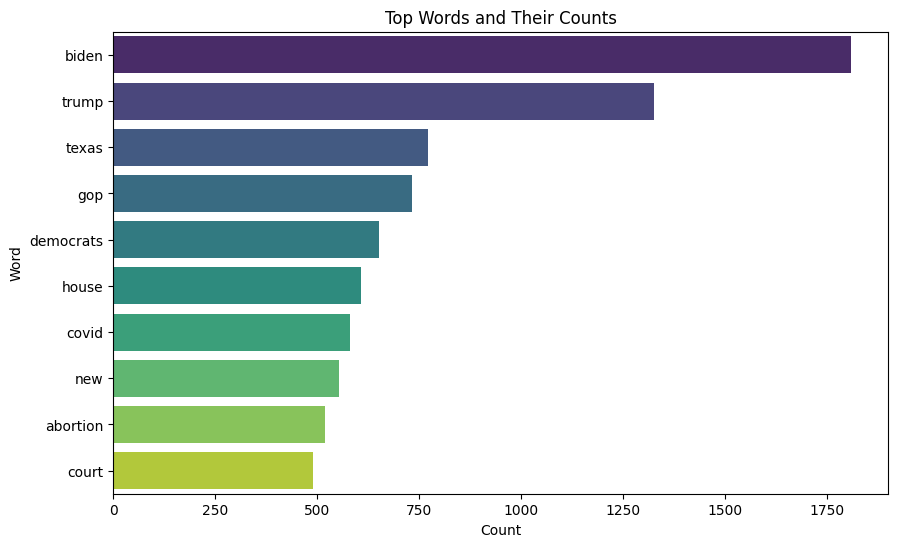

In [8]:
words, word_count = top_n_words(top_n = 10, count_vectorizer = count_vectorizer, data = data.title)
plt.figure(figsize=(10, 6))
sns.barplot(x=word_count, y=words, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top Words and Their Counts')
plt.show()



#### Text preprocessing for topic modelling

In [9]:
cnt_vec = CountVectorizer(stop_words = 'english', max_features = 40000)
text_sample = data['title'].sample(n=10000, random_state=0).values

print('Headline before vectorization: {}'.format(text_sample[152]))

small_document_term_matrix = cnt_vec.fit_transform(text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[152]))

Headline before vectorization: GOP Lawmaker Deletes Tweet Comparing Vaccine Mandates to the Holocaust
Headline after vectorization: 
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 8 stored elements and shape (1, 6952)>
  Coords	Values
  (0, 3738)	1
  (0, 6603)	1
  (0, 2695)	1
  (0, 3498)	1
  (0, 1669)	1
  (0, 6446)	1
  (0, 1262)	1
  (0, 2946)	1


In [10]:
n_topics = 10

In [11]:
lsa_model = TruncatedSVD(n_components = n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [12]:
def get_keys(topic_matrix):
    keys = topic_matrix.argmax(axis = 1).tolist()
    return keys

#keys = get_keys(lsa_topic_matrix)

def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

#keys_to_counts(keys)

In [13]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [14]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [15]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, cnt_vec)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  comment bomber denies rips rna apology suicide ilhan abortion lauren
Topic 2:  biden afghanistan joe manchin climate trump plan administration senate says
Topic 3:  texas abortion law court supreme ban rights roe justice wade
Topic 4:  trump election jan capitol says house gop committee january congress
Topic 5:  covid new vaccine mask state 19 desantis florida republicans governor
Topic 6:  democrats house white senate infrastructure tax trillion plan committee republicans
Topic 7:  court supreme roe wade eviction overturn moratorium decision ruling case
Topic 8:  white border migrants beijing horseback announce expected agents guards racism
Topic 9:  says gop state house governor january white china school new
Topic 10:  gop election arizona republican audit rep lawmaker jan mccarthy candidate


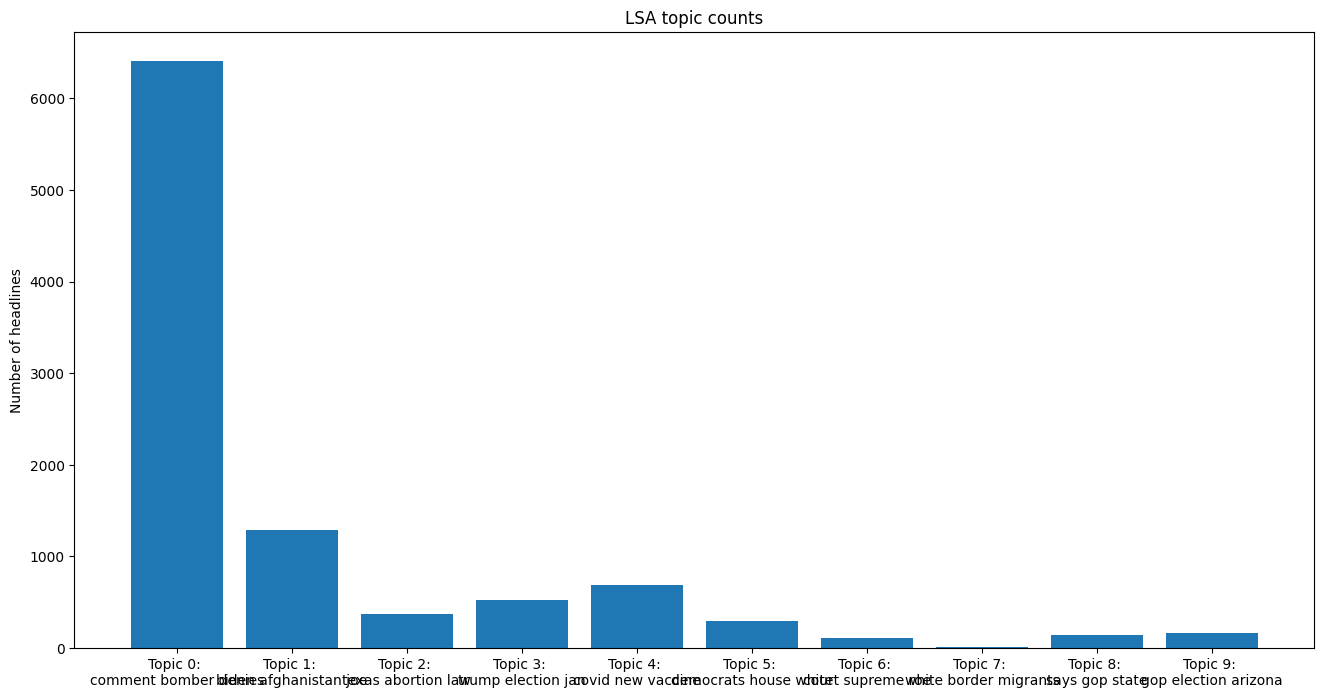

In [16]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, cnt_vec)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

In [17]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.012s...
[t-SNE] Computed neighbors for 10000 samples in 1.635s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.976479
[t-SNE] KL divergence after 2000 iterations: 0.279425


In [18]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [19]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [20]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, cnt_vec)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), min_width=700, height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

#### LDA

In [21]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [22]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [23]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, cnt_vec)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  biden senate infrastructure texas justice trillion joe agenda democrats bipartisan
Topic 2:  new america greene taylor biden cuomo trump marjorie city people
Topic 3:  trump house jan gop capitol committee white texas says biden
Topic 4:  texas abortion ban republican biden new law trump congress house
Topic 5:  court biden supreme abortion climate roe democrats republicans new manchin
Topic 6:  biden arizona trump audit sinema gop election say democrats senate
Topic 7:  trump election mask says school gop state mandates florida governor
Topic 8:  biden covid trump says 19 desantis border vaccine new democracy
Topic 9:  democrats biden voting afghanistan rights tax gop california recall texas
Topic 10:  comment desantis high signs enforcing medications goes hit vaccine teachers


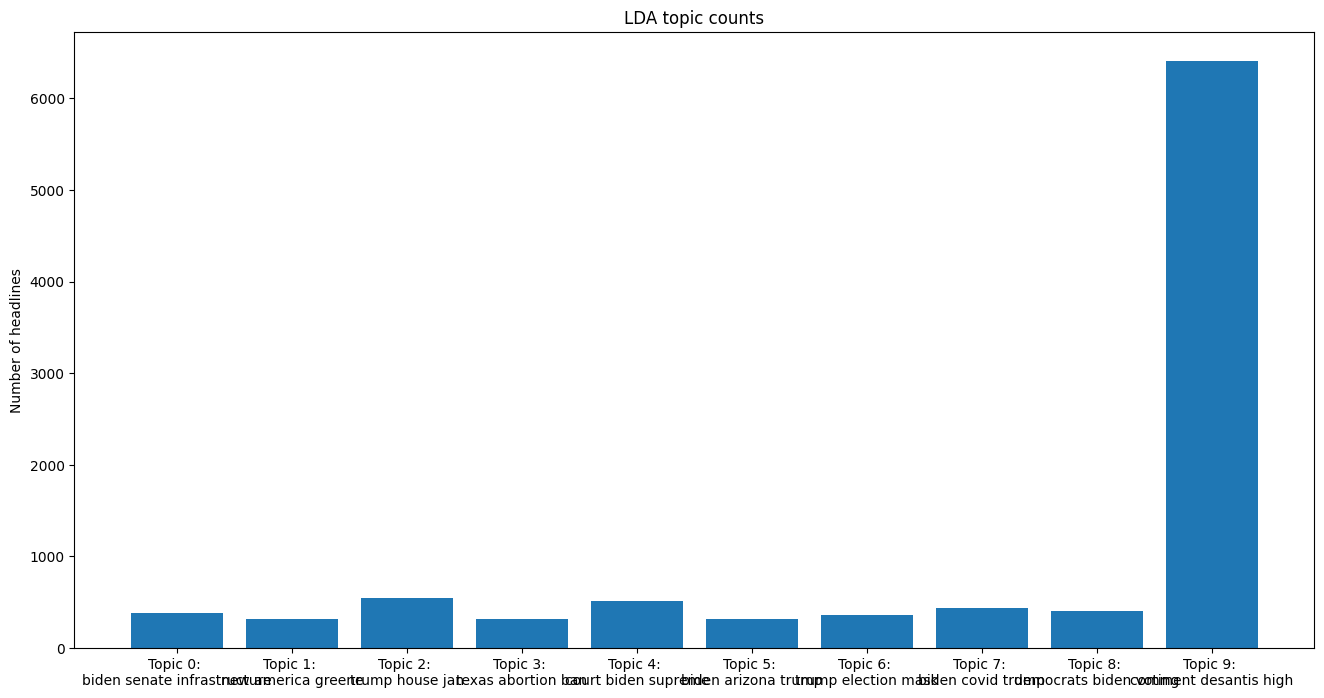

In [24]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, cnt_vec)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [25]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 1.612s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.225163
[t-SNE] KL divergence after 2000 iterations: 0.531438


In [26]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, cnt_vec)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), min_width=700, height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)